In [1]:
import os
import sys

# adding classes folder to system path
sys.path.insert(0, os.path.abspath('..') + '/gispy')

import re
import textract
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gist import GIS

def read_word_text(file_path):
    # reading the text from file
    text = textract.process(file_path)
    text = text.decode('utf-8')

    # replacing more than three new line characters with only two
    text = re.sub(r'[\n]{3,}', '\n\n', text)
    
    return text

## Report vs. Opinion

In [2]:
file_path = '../data/wolfe/Report_vs_Opinion/Report_Opinion_Comparison.docx'
text = read_word_text(file_path)

In [3]:
df = pd.DataFrame(columns=['title', 'type', 'url', 'text'])
lines = text.split('\n')

i = 4
doc_text = []
doc_title = lines[0] 
doc_url = lines[2]

while i < len(lines):
    if lines[i].startswith('Opinion-') or lines[i].startswith('Report-'):
        df = df.append({'title': doc_title, 'type': doc_title.split('-')[0].lower(), 'url': doc_url, 'text': '\n'.join(doc_text)}, ignore_index=True)
        doc_title = lines[i]
        doc_url = lines[i+2]
        doc_text = []
        i += 4
    else:
        doc_text.append(lines[i])
        i += 1

In [4]:
df.head(3)

,title,type,url,text
0,Report-Hawking,report,https://www.usatoday.com/story/news/2018/03/14...,"Stephen Hawking, one of the world's foremost t..."
1,Opinion-Hawking,opinion,https://www.usatoday.com/story/news/2018/03/14...,"Stephen Hawking, one of the greatest scientist..."
2,Report-Gun control,report,https://www.usatoday.com/story/news/politics/2...,WASHINGTON — As students across the country pr...


In [5]:
df.to_excel('report_vs_opinion.xlsx')

### Creating text files

In [5]:
doc_folder = '../data/documents'
for idx, row in df.iterrows():
    with open('{}/{}_{}.txt'.format(doc_folder, row['type'], idx), 'w') as text_file:
        text_file.write(row['text'])

### Compute `GIS` using `GisPy`

In [2]:
df = pd.read_csv('../gispy/ro.csv')

df_yes = df[df['d_id'].apply(lambda x: x.startswith('opinion_'))]
df_no = df[df['d_id'].apply(lambda x: x.startswith('report_'))]

print('[gist=yes] mean: {}'.format(round(statistics.mean(df_yes['gis']), 2)))
print('[gist=no] mean: {}'.format(round(statistics.mean(df_no['gis']), 2)))

[gist=yes] mean: -0.19
[gist=no] mean: -0.59


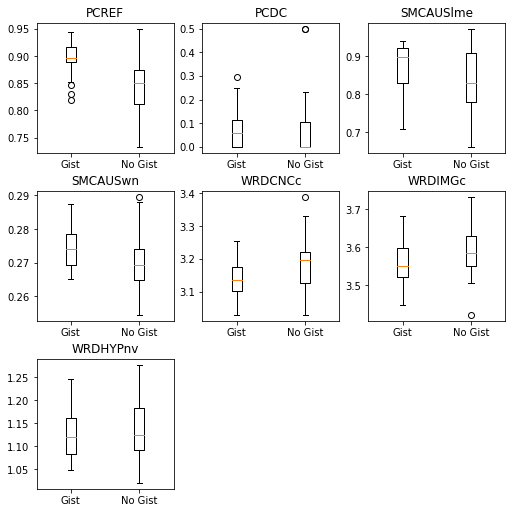

In [3]:
# formula = PCREFz + PCDCz + (zSMCAUSlsa - zSMCAUSwn) - PCCNCz - zWRDIMGc - zWRDHYPnv
cols = [["PCREFz", 0, 0], ["PCDCz", 0, 1], ["zSMCAUSlsa", 0, 2], ["zSMCAUSwn", 1, 0], 
        ["PCCNCz", 1, 1], ["zWRDIMGc", 1, 2], ["zWRDHYPnv", 2, 0]]

cols_gispy = [["PCREF", 0, 0], ["PCDC", 0, 1], ["SMCAUSlme", 0, 2], ["SMCAUSwn", 1, 0], 
        ["WRDCNCc", 1, 1], ["WRDIMGc", 1, 2], ["WRDHYPnv", 2, 0]]

fig, axis = plt.subplots(3, 3, figsize=(7,7), constrained_layout=True)

for col in cols_gispy:
    axis[col[1], col[2]].boxplot([df_yes[col[0]], df_no[col[0]]], labels=['Gist', 'No Gist'])
    axis[col[1], col[2]].set_title(col[0])

axis[2, 1].set_axis_off()
axis[2, 2].set_axis_off()

fig.savefig('aaa.pdf')

## Methods vs. Discussion

In [2]:
file_path = '../data/wolfe/Methods_vs_Discussion/Wolfe_methods_and_discussion_comparison.docx'
text = read_word_text(file_path)

# ARTICLE
# METHODS
# DISCUSSION

df = pd.DataFrame(columns=['title', 'methods', 'discussion'])
lines = text.split('\n')

article_title = ""
methods = []
discussion = []

i = 0

while i < len(lines):
    if lines[i].strip().lower().startswith('article'):
        article_title = ' '.join(lines[i].split(':')[1:]).strip()
        i += 4
        while i < len(lines) and not lines[i].lower().startswith('discussion'):
            methods.append(lines[i])
            i += 1
        i += 2
        while i < len(lines) and not lines[i].strip().lower().startswith('article'):
            discussion.append(lines[i])
            i += 1

        if article_title != "" and len(methods) > 0 and len(discussion) > 0:
            df = df.append({'title': article_title, 'methods': '\n'.join(methods), 'discussion': '\n'.join(discussion)}, ignore_index=True)
            article_title = ""
            methods = []
            discussion = []

print(len(df), i)

25 545


In [3]:
df.head(3)

,title,methods,discussion
0,Common Modality Effects in Immediate Free Reca...,Forty participants from the University of Esse...,A third feature of our data that may constrain...
1,Retuning of Lexical-Semantic Representations ...,Thirty-three native British English speakers p...,"Finally, in contrast to these two views, which..."
2,Threat of Shock and Aversive Inhibition Induc...,Sixty-two healthy participants (39 females; ag...,"As a potential caveat, it should be noted that..."


In [4]:
df.reset_index()
df.to_excel('../data/methods_vs_discussion.xlsx')

### Create text files

In [5]:
doc_folder = '../data/documents'
for idx, row in df.iterrows():
    with open('{}/m_{}.txt'.format(doc_folder, idx), 'w') as text_file:
        text_file.write(row['methods'])
    with open('{}/d_{}.txt'.format(doc_folder, idx), 'w') as text_file:
        text_file.write(row['discussion'])

### Compute GIS - using `CohMetrix`

In [4]:
df = pd.read_csv('../data/wolfe_cohmetrix.csv')
df_scores = GIS().score(df, wolfe=True)

id_col = 'TextID'

df_yes = df[df[id_col].apply(lambda x: x.split("_")[-2].endswith('d'))]
df_no = df[df[id_col].apply(lambda x: x.split("_")[-2].endswith('m'))]

scores = {'yes': [], 'no': []}

for idx, row in df_scores.iterrows():
    if row[id_col].split("_")[-2].endswith('d'):
        scores['yes'].append(float(row['gis']))
    else:
        scores['no'].append(float(row['gis']))

scores_yes = np.array(scores['yes'])
scores_no = np.array(scores['no'])

print('[gist=yes] mean: {}'.format(round(statistics.mean(scores_yes), 2)))
print('[gist=no] mean: {}'.format(round(statistics.mean(scores_no), 2)))

[gist=yes] mean: 2.93
[gist=no] mean: -2.02


### Compute GIS - using `GisPy`

In [9]:
# df = pd.read_csv('../gispy/md_new.csv')
# df = GIS().score(df, wolfe=True, gispy=True)
# df.to_csv('../gispy/md_new.csv')

In [4]:
import copy 
df = pd.read_csv('../gispy/md_gispy_v1.csv')

df_new = GIS().score(df, wolfe=False, gispy=True)

df_yes = copy.deepcopy(df_new[df_new['d_id'].apply(lambda x: x.startswith('d_'))])
df_no = copy.deepcopy(df_new[df_new['d_id'].apply(lambda x: x.startswith('m_'))])

#df_yes = GIS().score(df_yes, wolfe=False, gispy=True)
#df_no = GIS().score(df_no, wolfe=False, gispy=True)

print('[gist=yes] mean: {}'.format(round(statistics.mean(df_yes['gis']), 2)))
print('[gist=no] mean: {}'.format(round(statistics.mean(df_no['gis']), 2)))

[gist=yes] mean: 2.39
[gist=no] mean: -2.39


In [3]:
PCREFz = list(df_yes["PCREFz"])
PCDCz = list(df_yes["PCDCz"])
PCCNCz = list(df_yes["PCCNCz"])
zSMCAUSlsa = list(df_yes["zSMCAUSlsa"])
zSMCAUSwn = list(df_yes["zSMCAUSwn"])
zWRDIMGc = list(df_yes["zWRDIMGc"])
zWRDHYPnv = list(df_yes["zWRDHYPnv"])
gis_yes = statistics.mean(PCREFz) + statistics.mean(PCDCz) + (statistics.mean(zSMCAUSlsa) - statistics.mean(zSMCAUSwn)) - statistics.mean(PCCNCz) - statistics.mean(zWRDIMGc) - statistics.mean(zWRDHYPnv)

PCREFz = list(df_no["PCREFz"])
PCDCz = list(df_no["PCDCz"])
PCCNCz = list(df_no["PCCNCz"])
zSMCAUSlsa = list(df_no["zSMCAUSlsa"])
zSMCAUSwn = list(df_no["zSMCAUSwn"])
zWRDIMGc = list(df_no["zWRDIMGc"])
zWRDHYPnv = list(df_no["zWRDHYPnv"])
gis_no = statistics.mean(PCREFz) + statistics.mean(PCDCz) + (statistics.mean(zSMCAUSlsa) - statistics.mean(zSMCAUSwn)) - statistics.mean(PCCNCz) - statistics.mean(zWRDIMGc) - statistics.mean(zWRDHYPnv)

print(gis_yes, gis_no)

2.3887716801056933 -2.3887716801056946


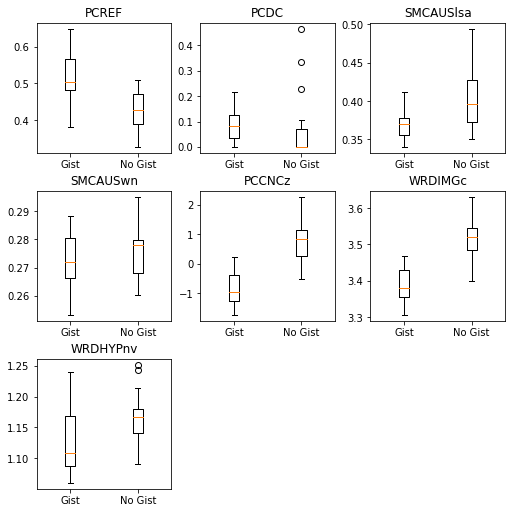

In [8]:
# formula = PCREFz + PCDCz + (zSMCAUSlsa - zSMCAUSwn) - PCCNCz - zWRDIMGc - zWRDHYPnv
cols = [["PCREFz", 0, 0], ["PCDCz", 0, 1], ["zSMCAUSlsa", 0, 2], ["zSMCAUSwn", 1, 0], 
        ["PCCNCz", 1, 1], ["zWRDIMGc", 1, 2], ["zWRDHYPnv", 2, 0]]

cols_gispy = [["PCREF", 0, 0], ["PCDC", 0, 1], ["SMCAUSlsa", 0, 2], ["SMCAUSwn", 1, 0], 
        ["PCCNCz", 1, 1], ["WRDIMGc", 1, 2], ["WRDHYPnv", 2, 0]]

fig, axis = plt.subplots(3, 3, figsize=(7,7), constrained_layout=True)

for col in cols_gispy:
    axis[col[1], col[2]].boxplot([df_yes[col[0]], df_no[col[0]]], labels=['Gist', 'No Gist'])
    axis[col[1], col[2]].set_title(col[0])

axis[2, 1].set_axis_off()
axis[2, 2].set_axis_off()

fig.savefig('aaa.pdf')

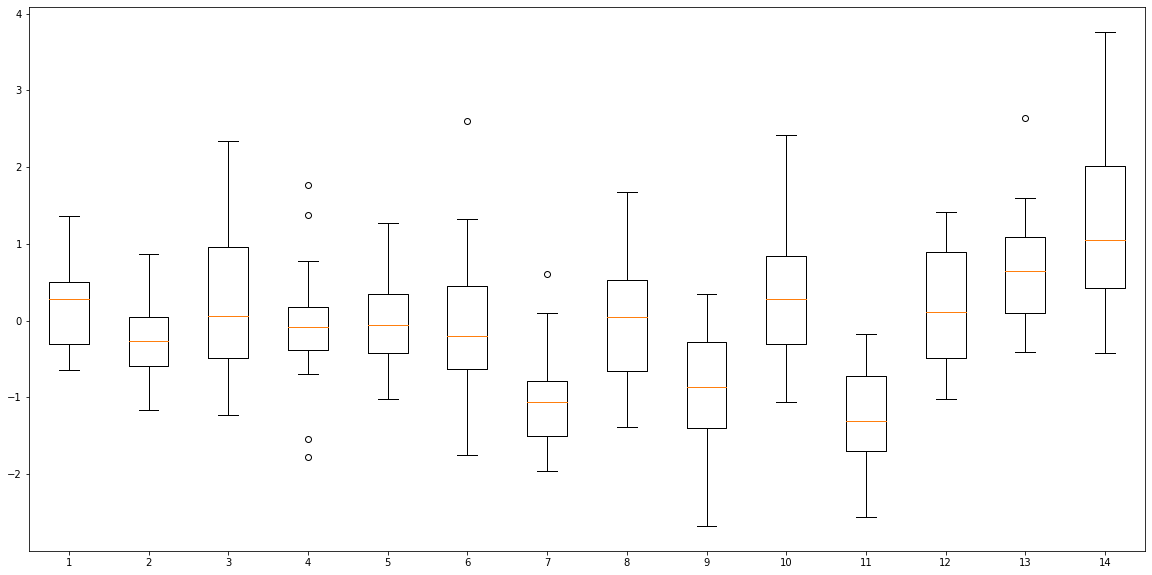

In [19]:
# formula = PCREFz + PCDCz + (zSMCAUSlsa - zSMCAUSwn) - PCCNCz - zWRDIMGc - zWRDHYPnv
cols = ["PCREFz", "PCDCz", "zSMCAUSlsa", "zSMCAUSwn", "PCCNCz", "zWRDIMGc", "zWRDHYPnv"]

fig = plt.figure(figsize =(20, 10))

plots = []

for col in cols:
    plots.append(df_yes[col])
    plots.append(df_no[col])

# Creating plot
plt.boxplot(plots)

# show plot
plt.show()

In [17]:
len(plots)

14

## NCI Coh-Metrix Scored
There are two types of text for each disease: 1) `Patient` version, and 2) `Health Professional (HP)` version. And for each type, there are different texts separately annotated for gist and verbatim (T1, T2, T3, etc.) Based on Chris Wolfe: "the articles for Physicians (HP, I guess) tended to be more gist whereas the ones for patients tended to be more verbatim"

For now, since there are no detailed scores available for different texts, we don’t use the NCI-related texts for evaluating our tool.


In [9]:
file_paths = ['../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Mitch.docx',
              '../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Tatum.docx',
              '../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Vasanthi.docx']

In [10]:
df = pd.DataFrame(columns=['title', 'url', 'text'])

for file_path in file_paths:
    lines = read_word_text(file_path).split('\n')
    i = 4
    title = lines[0]
    url = lines[2]
    current_text = []
    while i < len(lines):
        if lines[i].startswith('https'):
            # saving the current article
            df = df.append({'title': title, 'url': url, 'text': '\n'.join(current_text)}, ignore_index=True)
            title = lines[i-2]
            url = lines[i]
            current_text = []
            i += 1
        else:
            current_text.append(lines[i])
            i += 1

In [11]:
df.head(3)

,title,url,text
0,Leukemia/Patient Version,https://www.cancer.gov/types/leukemia,OVERVIEW\n\nLeukemia is cancer of the blood ce...
1,Leukemia/HP Version,https://www.cancer.gov/types/leukemia/hp,\nT1\n\nGeneral Information About Adult Acute ...
2,Adrenocortical Carcinoma/Patient Version,https://www.cancer.gov/types/adrenocortical,\nOVERVIEW\n\nAdrenocortical cancer is a rare ...


In [12]:
df.to_excel('nci_cohmetrix_scored.xlsx')

In [9]:
a = [1, 2, 3, 4]
import itertools
pairs = set(itertools.combinations(a, r=2))
for pair in pairs:
    print(pair)

(2, 4)
(1, 2)
(3, 4)
(1, 4)
(2, 3)
(1, 3)


In [7]:
t = [2,2,2,2,4]
c = list(itertools.combinations(t, 4))
print(c)
unq = set(c)
print(unq)

[(2, 2, 2, 2), (2, 2, 2, 4), (2, 2, 2, 4), (2, 2, 2, 4), (2, 2, 2, 4)]
{(2, 2, 2, 2), (2, 2, 2, 4)}
